In [27]:
import os
import clip
import torch
import textwrap
import replicate
import numpy as np
import pandas as pd
import qdrant_client
from PIL import Image
from pathlib import Path
from llama_index import (
                        ServiceContext,
                        SimpleDirectoryReader,
                        )
import matplotlib.pyplot as plt
import yaml, os, openai, textwrap
from llama_index.schema import TextNode
from llama_index.schema import ImageDocument
from llama_index.embeddings import FastEmbedEmbedding
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.vector_stores import VectorStoreQuery
from llama_index import set_global_service_context
from llama_index.llm_predictor import LLMPredictor
from llama_index.llms import AzureOpenAI

In [2]:
with open('/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['REPLICATE_API_TOKEN'] = credentials['REPLICATE_API_TOKEN']

In [3]:
chat_llm = LLMPredictor(
                        llm=AzureOpenAI(
                                        deployment_name=credentials['AD_DEPLOYMENT_ID'],
                                        model=credentials['AD_ENGINE'],
                                        api_key=credentials['AD_OPENAI_API_KEY'],
                                        api_version=credentials['AD_OPENAI_API_VERSION'],
                                        azure_endpoint=credentials['AD_OPENAI_API_BASE']
                                        )
                        )
embedding_llm = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")

service_context = ServiceContext.from_defaults(
                                                llm_predictor=chat_llm,
                                                embed_model=embedding_llm,
                                                )

set_global_service_context(service_context)

In [4]:
df_styles = pd.read_csv('preprocessed_data/styles.csv') 
df_styles

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,31588.jpg,Men,Apparel,Topwear,Tshirts,Maroon,Summer,2012.0,Casual,Mark Taylor Men Printed Maroon T-shirt
1,28697.jpg,Women,Apparel,Topwear,Kurtas,Black,Summer,2012.0,Ethnic,W Women Printed Black Kurta
2,14099.jpg,Women,Apparel,Topwear,Tops,Pink,Fall,2011.0,Casual,Flying Machine Women Solid Pink Tops
3,16361.jpg,Men,Apparel,Topwear,Shirts,Maroon,Fall,2011.0,Formal,Peter England Men Stripes Maroon Shirt
4,3534.jpg,Women,Apparel,Topwear,Tshirts,Black,Summer,2011.0,Casual,Myntra Women's I Want You Black T-shirt
...,...,...,...,...,...,...,...,...,...,...
484,8395.jpg,Men,Apparel,Topwear,Sweaters,Grey,Fall,2011.0,Sports,ADIDAS Men Sf Str Slv Fs Ca Grey Sweaters
485,8361.jpg,Girls,Apparel,Topwear,Tshirts,Green,Fall,2011.0,Casual,Doodle Girl's Tonight Night Rock Light Green K...
486,3789.jpg,Men,Apparel,Topwear,Tshirts,White,Summer,2011.0,Casual,Basics Men White & Green Striped Polo T-shirt
487,33250.jpg,Men,Apparel,Topwear,Shirts,White,Summer,2012.0,Formal,Arrow Men Green & Blue Check Shirt


# Text Query Engine

In [5]:
productDisplayName = df_styles['productDisplayName'].tolist()

text_client = qdrant_client.QdrantClient(location=":memory:")
text_vector_store = QdrantVectorStore(
                                    client=text_client,
                                    collection_name="text_collection",
                                    )   
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)
# text_nodes = [TextNode(text=productDisplayName[i]) for i in range(len(productDisplayName))]

text_nodes = []
for i in range(len(productDisplayName)):
    meta_data = {
                "gender" : df_styles['gender'][i],
                "subCategory" : df_styles['subCategory'][i],
                "articleType" : df_styles['articleType'][i],    
                "baseColour" : df_styles['baseColour'][i],
                "season" : df_styles['season'][i],
                "usage" : df_styles['usage'][i],
                }
    
    text_nodes.append(TextNode(text=productDisplayName[i], metadata=meta_data))


product_text_index = VectorStoreIndex(
                                    text_nodes,
                                    storage_context=storage_context
                                    )
product_text_engine = product_text_index.as_query_engine()

In [24]:
str(product_text_engine.query("black dress"))

'There are two black dresses mentioned in the context information. One is a Forever New Women Porcelain Black Dress which is suitable for casual wear in the fall season. The other is a Femella Women Black Pleated Dress which is suitable for casual wear in the summer season.'

# Image Query engine

In [9]:
image_metadata_dict = {}

df_images = pd.read_csv('preprocessed_data/images.csv')
image_files = df_images['filename'].tolist()
image_files = [f"images/{image_files[i]}" for i in range(len(image_files))]
image_urls = df_images['link'].tolist()

for image_file, image_url in zip(image_files, image_urls):
    image_filename = os.path.basename(image_file)
    image_file_path = os.path.abspath(image_file)
    image_metadata_dict[image_filename] = {
                                          "filename": image_filename,
                                          "img_path": image_file_path,
                                          "url": image_url,
                                          }

In [11]:
image_metadata_dict

{'14099.jpg': {'filename': '14099.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/07-multimodal-fashion-recommendation-app/images/14099.jpg',
  'url': 'http://assets.myntassets.com/v1/images/style/properties/1c2d217895f9a1bf02a20b09084491da_images.jpg'},
 '37934.jpg': {'filename': '37934.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/07-multimodal-fashion-recommendation-app/images/37934.jpg',
  'url': 'http://assets.myntassets.com/v1/images/style/properties/1d55630904e97e224fdb47b8ee554351_images.jpg'},
 '58495.jpg': {'filename': '58495.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/07-multimodal-fashion-recommendation-app/images/58495.jpg',
  'url': 'http://assets.myntassets.com/v1/images/style/properties/Tonga-Women-Printed-White-Dress_bfb2465489bfda0db48b2139c811ba87_images.jpg'},
 '40270.jpg': {'filename': '40270.jpg',
  'img_path': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/07-multimodal

In [13]:
def plot_images(image_metadata_dict):
    images = []
    images_shown = 0
    for image_filename in image_metadata_dict:
        img_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_path):
            # open the image file and convert it to RGB colorspace.
            filename = image_metadata_dict[image_filename]["filename"]
            try:
                image = Image.open(img_path).convert("RGB")
                # plot the image in a subplot of an 8x8 grid, also disables the tick labels on the axes to make the plot cleaner.
                plt.subplot(8, 8, len(images) + 1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])

                images.append(filename)
                images_shown += 1
                if images_shown >= 64:
                    break
                
            except:
                pass

    plt.tight_layout()
    plt.show()

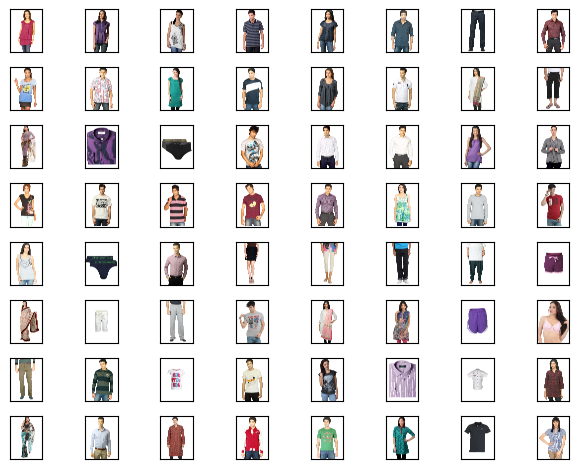

In [14]:
plot_images(image_metadata_dict)

In [15]:
model, preprocess = clip.load("ViT-B/32")
model = model.to("mps")
input_resolution = model.visual.input_resolution


context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [16]:
device = "mps"
print("Consuming:", device)

img_emb_dict = {}
with torch.no_grad():
    for image_filename in image_metadata_dict:
        img_file_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_file_path):
            try:
                image = (
                    preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
                )
                image_features = model.encode_image(image)
                img_emb_dict[image_filename] = image_features
            except:
                pass

Consuming: mps


In [17]:
img_documents = []
for image_filename in image_metadata_dict:
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]
        url = image_metadata_dict[image_filename]["url"]

        newImgDoc = ImageDocument(
                                text=filename, 
                                metadata={
                                        "filepath": filepath,
                                        "url": url
                                        })

        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

image_vector_store = QdrantVectorStore(
                                    client=text_client, 
                                    collection_name="image_collection"
                                    )

storage_context = StorageContext.from_defaults(vector_store=image_vector_store)
product_image_index = VectorStoreIndex.from_documents(
                                            img_documents,
                                            storage_context=storage_context
                                            )

In [18]:
def retrieve_results_from_image_index(query):
    text = clip.tokenize(query).to(device)
    query_embedding = model.encode_text(text).tolist()[0]
    image_vector_store_query = VectorStoreQuery(
                                                query_embedding=query_embedding,
                                                similarity_top_k=1, # only return 1 image
                                                mode="default",
                                                )

    image_retrieval_results = image_vector_store.query(image_vector_store_query)
    return image_retrieval_results

In [21]:
image_retrieval_results = retrieve_results_from_image_index('black dress')

In [22]:
image_retrieval_results.nodes, image_retrieval_results.similarities

([ImageNode(id_='b3af7610-e118-48bf-bc9b-b106bf2e45ba', embedding=None, metadata={'filepath': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/07-multimodal-fashion-recommendation-app/images/18716.jpg', 'url': 'http://assets.myntassets.com/v1/images/style/properties/0f9ce538b01bc50d180f355880360464_images.jpg'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='ea2524bc-bce5-465e-a558-9040e974ccec', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'filepath': '/Users/1zuu/Desktop/LLM RESEARCH/awesome-llm-projects/07-multimodal-fashion-recommendation-app/images/18716.jpg', 'url': 'http://assets.myntassets.com/v1/images/style/properties/0f9ce538b01bc50d180f355880360464_images.jpg'}, hash='e1c560e476dd879823bc885e0e2cefa2c8c9814b241075bb1cd0b16a950518aa'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='cdceab75-5b29-4ea6-9af1-6f9c0e41ab9a', node_type=<ObjectType.IMAGE: '2'>, metadata={'f

# Multi Modality

In [23]:
def plot_image_retrieve_results(image_retrieval_results):
    plt.figure(figsize=(16, 5))

    img_cnt = 0
    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_path = returned_image.metadata["filepath"]
        image_url = returned_image.metadata["url"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

        return image_url
    
def llava_inference(
                    image,
                    prompt,
                    max_tokens = 100,
                    temperature = 0.5
                    ):
    output = replicate.run(
                            "yorickvp/llava-13b:c293ca6d551ce5e74893ab153c61380f5bcbd80e02d49e08c582de184a8f6c83",
                            input={
                                    "image": image,
                                    "prompt": prompt,
                                    "max_tokens": max_tokens,
                                    "temperature": temperature
                                    }
                        )
    return output

In [25]:
def multimodal_retrivial(
                        query,
                        prompt = """
                        Consider below context to provide your suggestions on provided image's suitability.

                        {context}
                        """):
    image_retrieval_results = retrieve_results_from_image_index(query)
    image_url = plot_image_retrieve_results(image_retrieval_results)
    context = str(product_text_engine.query(query))

    output = llava_inference(
                            image_url,
                            prompt.format(context=context)
                            )
    return output

The woman in the image is wearing a black dress, which could be appropriate for evening wear.
However, the specific details of the dress and the occasion are not provided in the context
information.


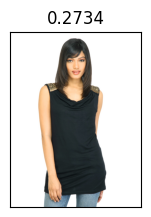

In [31]:
output = multimodal_retrivial('black dress for evening')
print(textwrap.fill(output, width=100))

Based on the context, the man in the image is wearing a red shirt, which seems to be a casual polo
shirt. It is not suitable for office use as it is too casual for professional settings. To dress
appropriately for an office environment, he should opt for a more formal shirt, such as the Arrow
Men Check Red Shirts or Genesis Men Check Red Shirts, both of which are suitable for office use.


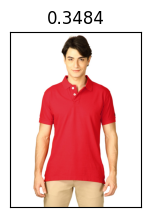

In [32]:
output = multimodal_retrivial('red shirt for office')
print(textwrap.fill(output, width=100))